<a href="https://colab.research.google.com/github/amishra06/Identify-Characters-from-Product-Images/blob/master/Identify_Characters_from_Product_Images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


##  Identifying Characters from Product Images

Goal is to Identify the “characters” from each image from a list of  42 possible characters.

Data set consists of product images like t-shirts, bags, keychains, mobile covers, etc. with characters graphics. The master data set has been split into training and test data sets for the contest tasks. 






**Importing modules**

I am using fastai for this multi class image classification problem.

In [0]:
from fastai import *
from fastai.vision import *
import os as os
from os import *
import random
from PIL import Image
from PIL import ImageFilter

**Arranging the Data**

Created the top folder named *Characters*, under that copyied the zipped  training data file and unzipped it. After unzipping, *CAX_Characters_Train* folder gets created. Under this folder there are subfolders whose names are class labels for particular set of product images and those images are under that class label subfolder. So we need to pick the class labels from these subfolders names

In [0]:
#path = Path('gdrive/My Drive/Colab Notebooks/Game of Deep Learning')
path = Path('Characters')
dest = path
#dest.mkdir(parents=True, exist_ok=True)
#dest.rmdir()

In [0]:
!mv Train.zip Characters/
!unzip -d Characters Characters/Train.zip

In [0]:
flist=(path/'CAX_Characters_Train').ls()
classes = [os.path.basename(f) for f in flist]

In [0]:
classes

Checking if training data is balanced or not

In [0]:
filelist = {}
for dirpath, dirnames, filenames in os.walk(path/'CAX_Characters_Train'):
    N_c = len(filenames)
    #print("Files in ", dirpath, N_c)
    filelist.update({dirpath: N_c}) 
sorted(((v,k) for k,v in filelist.items()))

To balance the unbalanced training set, image files are augmented using python pillow module and saved. This is done for the classes for which there is less training data. There are twenty nine classes for which training images are below two hundred.

In [0]:
classpaths = []
for dirpath, dirnames, filenames in os.walk(path/'CAX_Characters_Train'):
    N_c = len(filenames)
    if(0 < N_c < 200):
       classpaths.append(dirpath)
       #classpaths.append(os.path.basename(dirpath))
       

In [0]:
classpaths


In [18]:
for cpath in classpaths:
    fullpath = '/content/' + cpath
    os.chdir(fullpath)
    cwd = os.getcwd()
    for imagefile in os.listdir(cwd):
        im=Image.open(imagefile)
        im=im.convert("RGB")
        im_blur=im.filter(ImageFilter.GaussianBlur)
        im_unsharp=im.filter(ImageFilter.UnsharpMask)
        im_blur.save('bl_'+imagefile)
        im_unsharp.save('un_'+imagefile)
        if(len(os.listdir(cwd)) >= 300):
            break

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


**Splitting the data in to train and validation set**

To work  with fastai's data block api we need to create validation set also. For that reason I am creating validation folder (Valid) in same  location where train set folder (CAX_Characters_Train) exists.  I am randomly shuffling the train set files and shifting 20 percent files to validation folder maintaining the same path structure as training data

In [0]:
def copy_to_valid(chosen_files,class_dir):
    for i in range (len(chosen_files)):
        os.rename(path/'CAX_Characters_Train'/class_dir/chosen_files[i], path/'Valid'/class_dir/chosen_files[i])

In [0]:
for classname in classes:
    os.makedirs(f'{path}/Valid/{classname}', exist_ok=True)
    pathfile = (path/'CAX_Characters_Train'/classname).ls()
    list_of_files = [os.path.basename(f) for f in pathfile]
    random.shuffle(list_of_files)
    n_files_moved=int(len(list_of_files)*0.25)
    selected_files = [list_of_files[m] for m in range(n_files_moved)]
    copy_to_valid(selected_files,classname)

**Data Augmentation and creation of databunch**

In [0]:
tfms = get_transforms(max_rotate=25, max_zoom=1.3, max_lighting=0.4, max_warp=0.3, xtra_tfms = [
        squish(),
    ])

In [0]:
data = (ImageList.from_folder(path)
       .split_by_folder(train='CAX_Characters_Train', valid='Valid')
       .label_from_folder()
       .transform(tfms, size=256)
       .databunch().normalize(imagenet_stats))

In [0]:
x,y = data.train_ds[0]

ben


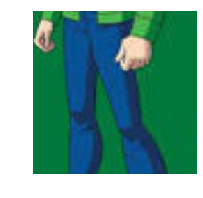

In [12]:
x.show()
print(y)

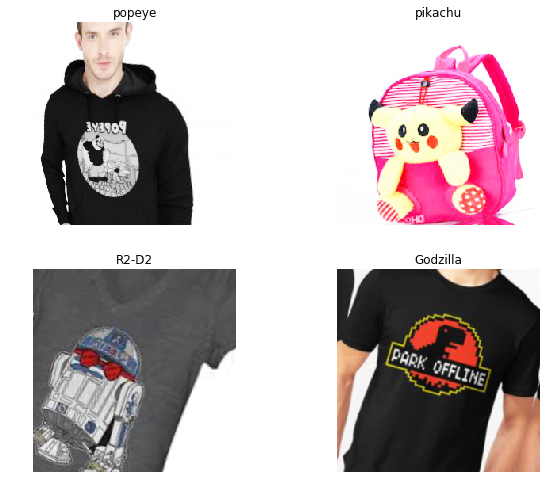

In [13]:
data.show_batch(rows=2, figsize=(9,7))

In [0]:
#data.classes, len(data.classes), data.c, len(data.train_ds), len(data.valid_ds)


**Training**

*  I am creating the CNN learner
*  Using  transfer learning with resnet50.
* Training data with discriminative learning rate




In [0]:
arch = models.resnet50

In [0]:
#acc_02 = partial(accuracy_thresh, thresh=0.2)
#f_score = partial(fbeta, thresh=0.2)
#accuracy??

In [19]:
learn = cnn_learner(data, arch, metrics=[error_rate], wd=0.02)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:03<00:00, 27098871.59it/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


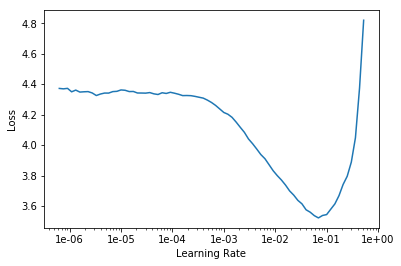

In [20]:
learn.lr_find()
learn.recorder.plot()

In [0]:
lr = 0.01

In [22]:
learn.fit_one_cycle(15, slice(lr))

epoch,train_loss,valid_loss,error_rate,time
0,2.206328,1.455305,0.385590,02:49
1,1.496592,1.040813,0.289526,02:51
2,1.266212,0.895810,0.256171,02:53
3,1.108870,0.814610,0.230153,02:53
4,0.941092,0.673629,0.191127,02:54
5,0.851541,0.665860,0.191127,02:54
6,0.689166,0.515224,0.154103,02:54
7,0.619804,0.476546,0.138092,02:54
8,0.522853,0.443212,0.128419,02:55
9,0.424278,0.392283,0.111074,02:56


In [0]:
learn.save('stage-1')

In [0]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


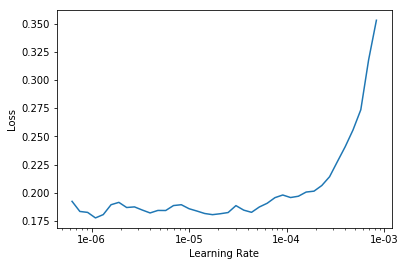

In [25]:
learn.lr_find()
learn.recorder.plot()

In [26]:
learn.fit_one_cycle(15, max_lr=slice(1e-5,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.209648,0.318295,0.094063,03:02
1,0.213613,0.313029,0.092061,03:04
2,0.203750,0.307756,0.091061,03:03
3,0.219016,0.304571,0.091394,03:04
4,0.185590,0.303120,0.088059,03:02
5,0.166716,0.285914,0.084056,03:03
6,0.143520,0.259426,0.072382,03:02
7,0.124245,0.260936,0.074716,03:03
8,0.110340,0.246308,0.066378,03:06
9,0.095969,0.243291,0.068712,03:05


In [27]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)

True

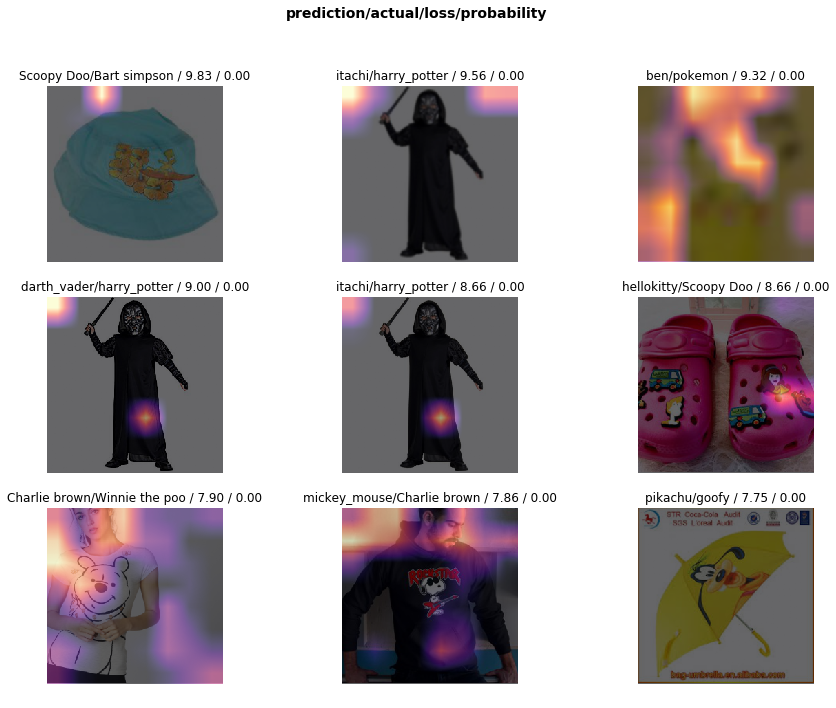

In [28]:
interp.plot_top_losses(9, figsize=(15,11))

In [42]:
interp.most_confused(min_val=2)

[('Cinderella', 'disney_princes', 15),
 ('disney_princes', 'Cinderella', 8),
 ('vegeta', 'Goku_1', 6),
 ('Goku_1', 'vegeta', 5),
 ('Charlie brown', 'Bart simpson', 4),
 ('Winnie the poo', 'Bart simpson', 4),
 ('Winnie the poo', 'Charlie brown', 4),
 ('Bart simpson', 'Charlie brown', 3),
 ('Tom and Jerry', 'Baloo', 3),
 ('goofy', 'Tom and Jerry', 3),
 ('popeye', 'donald_duck', 3),
 ('Bart simpson', 'Scoopy Doo', 2),
 ('Bart simpson', 'power_rangers', 2),
 ('Charlie brown', 'Scoopy Doo', 2),
 ('John Cena', 'Roman Reigns', 2),
 ('Roman Reigns', 'han-solo', 2),
 ('Scoopy Doo', 'Charlie brown', 2),
 ('Scoopy Doo', 'goofy', 2),
 ('Winnie the poo', 'disney_princes', 2),
 ('disney_princes', 'Baloo', 2),
 ('disney_princes', 'goofy', 2),
 ('disney_princes', 'toy_story_characters', 2),
 ('goofy', 'Baloo', 2),
 ('goofy', 'Godzilla', 2),
 ('goofy', 'mickey_mouse', 2),
 ('harry_potter', 'Roman Reigns', 2),
 ('harry_potter', 'darth_vader', 2),
 ('harry_potter', 'itachi', 2),
 ('toy_story_characters',

In [0]:
learn.save('stage-2')

In [0]:
learn.export()

**Prediction on test set**

In [0]:
!mv Test.zip Characters/
!unzip -d Characters Characters/Test.zip

In [0]:
test = (ImageList.from_folder(path/'test_characters_new'))

In [35]:
len(test)

3727

In [0]:
learn = load_learner(path, test=test)

In [0]:
preds, _ = learn.get_preds(ds_type=DatasetType.Test)

In [0]:
labelled_preds = [' '.join([learn.data.classes[i] for i,p in enumerate(pred) if p == max(pred)]) for pred in preds]

In [0]:
fnames = [os.path.basename(f) for f in learn.data.test_ds.items]

In [0]:
df = pd.DataFrame({'Filename':fnames, 'Prediction':labelled_preds}, columns=['Filename', 'Prediction'])

In [0]:
df.to_csv(path/'submission.csv', index=False)